In [134]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
np.set_printoptions(suppress=True)
import time
import pandas as pd
import itertools
import collections
from ipywidgets import interact, FloatSlider, IntSlider
import math

# Задание 1

## Генератор схемы Бернулли
Параметры: p --- вероятность успеха; d --- размер выборки
$$
  \mathbb{P}(x = k) = \begin{cases}
      1-p,&k = 0\\
      p,&k = 1\\
  \end{cases}
$$

In [135]:
def get_bernulli(p, d):
    if isinstance(d, (int, np.integer)):
        d = (d,)
    if p < 0 or p > 1:
        print("Некорректные параметры")
        return
    return (np.random.rand(*d) < p).astype(int)

In [136]:
p = 0.3
d = (5, 6)
print(get_bernulli(p, d))

[[1 0 0 0 1 0]
 [0 0 0 0 1 1]
 [0 1 0 0 1 1]
 [0 0 1 0 0 0]
 [1 1 1 1 0 0]]


## Генератор биномиального распределения
Параметры: p --- вероятность успеха, n --- число экспериментов; d --- размер выборки
$$
  \mathbb{P}(x = k) = C_n^k p^k (1 - p)^{n - k},\ k \in \mathbb{N}_0
$$

In [137]:
def get_binomial(p, n, d):
    if isinstance(d, (int, np.integer)):
        d = (d,)
    if p < 0 or p > 1 or n < 1:
        print("Некорректные параметры")
        return;
    return get_bernulli(p, (*d, n)).sum(axis = -1)

In [138]:
def interactive_binomial(n=10, p=0.5, sample_size=1000):
    """
    Интерактивная визуализация биномиального распределения

    Параметры:
    - n: количество испытаний
    - p: вероятность успеха в каждом испытании
    - sample_size: размер генерируемой выборки
    """
    # Генерация данных
    samples = get_binomial(n=n, p=p, d=sample_size)

    # Теоретические вероятности
    x = np.arange(0, n+1)
    probs = scipy.stats.binom.pmf(x, n=n, p=p)

    # Построение графиков
    plt.figure(figsize=(12, 6))

    # Гистограмма выборки
    plt.hist(samples, bins=np.arange(-0.5, n+1.5, 1),
             density=True, alpha=0.7, color='skyblue',
             edgecolor='black', label='Выборка')

    # Теоретическое распределение
    plt.stem(x, probs, linefmt='r-', markerfmt='ro',
             basefmt=' ', label='Теория')

    # Настройка графика
    plt.title(f'Биномиальное распределение (n={n}, p={p})')
    plt.xlabel('Число успехов')
    plt.ylabel('Вероятность')
    plt.xticks(np.arange(0, n+1, max(1, n//10)))
    plt.legend()
    plt.grid(alpha=0.3)
    plt.xlim(-0.5, n+0.5)
    plt.ylim(0, min(1, max(probs)*1.2))
    plt.show()

# Создаем интерактивный интерфейс
interact(
    interactive_binomial,
    n=IntSlider(min=1, max=50, step=1, value=10, description='Число испытаний (n):'),
    p=FloatSlider(min=0.01, max=0.99, step=0.01, value=0.5, description='Вероятность (p):'),
    sample_size=IntSlider(min=100, max=10000, step=100, value=1000, description='Размер выборки:')
);

interactive(children=(IntSlider(value=10, description='Число испытаний (n):', max=50, min=1), FloatSlider(valu…

## Генератор геометрического распределения
Функция вероятности геометрического распределения имеет вид $\mathbb{P}(X = n) = p(1 - p)^n$. Получим геометрическое распределение через экспоненциальное. Пусть $\xi \sim exp(\lambda)$, тогда $\lfloor \xi \rfloor \sim Geom(p)$, где $p = 1 - e^{-\lambda}$.
Покажем, что это так. Функция распределения имеет вид $F_\xi(x) = 1-e^{-\lambda x}$. Поэтому для $n \in \mathbb{N}_0$
$$
    \mathbb{P}(\lfloor \xi \rfloor = n) = \mathbb{P}(n \le \xi \le n + 1) = e^{-n\lambda} (1 - e^{-\lambda}) = (1 - p)^np
$$
Таким образом, моделирование геометрическое распределиня с параметром p сводится к моделированию экспоненциального распределения с параметром $\lambda = - \ln(1 - p)$.
Воспользуемся методом обращения функции распределения:
$$
    F_\xi^{-1}(y) = -\frac{1}{\lambda}\ln(1 - y)
$$
Пусть случайная величина $\xi$ имеет непрерывную и строго возрастающую функцию распределения $F_\xi$. Тогда $F_\xi^{-1}(U) \sim \xi,\ U \sim \mathcal{U}(0, 1)$
$$
    \mathbb{P}(F_\xi^{-1}(U) < x) = \mathbb{P}(U < F_\xi(x)) = F_\xi(x),
$$
поэтому $F_\xi^{-1}(U) \sim \xi$

In [139]:
def get_geometric(p, d):
    if isinstance(d, (int, np.integer)):
        d = (d,)
    if p < 0 or p > 1:
        print("Некорректные параметры")
        return;
    l = -np.log(1-p)
    return np.floor(-(1/l)*np.log(1 - np.random.rand(*d))).astype(int)

In [140]:
def interactive_geometric(p=0.5, sample_size=1000, max_k=20):
    """
    Интерактивная визуализация геометрического распределения

    Параметры:
    - p: вероятность успеха
    - sample_size: размер выборки
    - max_k: максимальное число испытаний для отображения
    """
    # Генерация данных
    samples = get_geometric(p=p, d=sample_size)

    # Теоретическое распределение (через scipy.stats.geom)
    k = np.arange(1, max_k + 1)
    probs = scipy.stats.geom.pmf(k, p)

    # Настройка графика
    plt.figure(figsize=(12, 6))

    # Гистограмма выборки
    plt.hist(samples, bins=np.arange(0.5, max_k + 1.5, 1),
             density=True, alpha=0.7, color='skyblue',
             edgecolor='black', label='Выборка')

    # Теоретическое распределение
    plt.scatter(k, probs, color='red', s=50, zorder=3, label='Теория')
    plt.plot(k, probs, 'r--', alpha=0.5)

    # Оформление
    plt.title(f'Геометрическое распределение (p={p:.2f})')
    plt.xlabel('Номер первого успешного испытания')
    plt.ylabel('Вероятность')
    plt.xticks(np.arange(1, max_k + 1, max(1, max_k//10)))
    plt.legend()
    plt.grid(alpha=0.3)
    plt.xlim(0.5, max_k + 0.5)
    plt.ylim(0, min(1, max(probs)*1.2))
    plt.show()

# Интерактивный интерфейс
interact(
    interactive_geometric,
    p=FloatSlider(min=0.01, max=0.99, step=0.01, value=0.5, description='Вероятность (p):'),
    sample_size=IntSlider(min=100, max=10000, step=100, value=1000, description='Размер выборки:'),
    max_k=IntSlider(min=5, max=50, step=1, value=20, description='Макс. испытаний:')
)

interactive(children=(FloatSlider(value=0.5, description='Вероятность (p):', max=0.99, min=0.01, step=0.01), I…

<function __main__.interactive_geometric(p=0.5, sample_size=1000, max_k=20)>

Распределение дискретной случайной величины X обладает свойством отсутствия памяти, если $\mathbb{P}(X > t + \tau |X \ge \tau) = \mathbb{P}(X > t)\ \forall t, \tau \in \mathbb{Z},\, t > 0$.
Для геометрического распределения $\mathbb{P}(X > t) = (1 - p)^{t + 1}$ и
$$
    \mathbb{P}(X > t + \tau |X \ge \tau) = \frac{\mathbb{P}(X > t + \tau,\, X \ge \tau)}{\mathbb{P}(X \ge \tau)} = \frac{(1 - p)^{t + \tau + 1}}{(1 - p)^{\tau}} = (X > t).
$$
Следовательно, геометрическое распределение обладает свойством отсутствия памяти.

## Игра в орлянку

Игра в орлянку --- бесконечная последовательность независимых испытаний с бросанием правильной монеты. Выйгрыш $S_n$ определяется как сумма по n испытаниям значений 1 и -1 в значении от выпавшей стороны. Проиллюстрируем поведение величины $Y(i) = \frac{S_i}{\sqrt n}$ как функцию номера испытания $i = 1, \dots ,n$ для отдельно взятой траектории.

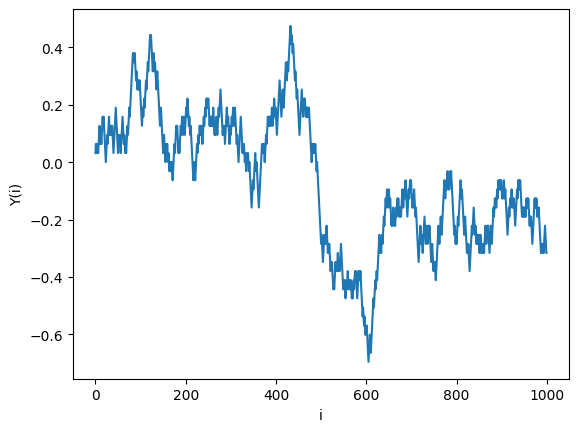

In [141]:
p = 0.5
N = 1000
s = 0
S = np.zeros((N, 1))
for i in range(N):
    r = 2*get_bernulli(0.5, (1, 1)) - 1
    s += r
    S[i] = s

S /= np.sqrt(N)
plt.plot(S)
plt.xlabel("i")
plt.ylabel("Y(i)")
plt.show()

Теоретическую оценку можно дать, используя центральную предельную теорему (ЦПТ). Она говорит, что если $\{X_i\}$ --- последовательность независимых одинаконово распределенных случайных величин с матожиданием $\mu$ и дисперсией $\sigma^2$, то
$$
    \frac{S_n - \mu n}{\sigma \sqrt n} \xrightarrow[n → \infty]{d} \mathcal{N}(0, 1),
$$
где $\mathcal{N}(0, 1)$ --- стандартное нормальное распределение.

В данном случае $\mu = 0,\, \sigma = 1$ и $Y(n) = \frac{S_n}{\sqrt n} \xrightarrow[n → \infty]{d} \mathcal{N}(0, 1)$.

# Задание 2

## Сингулярное распределение

Построим датчик сингулярного распределения, имеющий в качестве функции распределения канторову лестницу. Заметим, что из определения канторовой лестницы следует, что каждая цифра в троичной записи значения случайной величины равна 0 или 2 с вероятностью $\frac{1}{2}$. Его можно представить в виде $\alpha_1 \frac{1}{3} + \alpha_2 \frac{1}{9} + \dots \ $, где $\alpha_i \in \{0, 2\}$. Таким образом, будем использовать датчик распределения Бернулли и считать данную сумму до 20 члена (это даст достаточную точность).

In [142]:
def get_cantor(d):
    if isinstance(d, (int, np.integer)):
        d = (d,)
    N = 20 # точность приближения
    X = 0
    div = 1/3
    for i in range(N):
        X += 2*get_bernulli(0.5, d) * div
        div /= 3
    return X

In [143]:
d = (5, 6)
print(get_cantor(d))

[[0.76675471 0.32407547 0.29756502 0.03332869 0.07723954 0.66788978]
 [0.75032614 0.70329724 0.88981529 0.69991005 0.07783535 0.11068918]
 [0.32953944 0.099072   0.33025114 0.97520284 0.33206841 0.08325476]
 [0.23049205 0.69533228 0.30041026 0.77468423 0.70265371 0.96665542]
 [0.25010282 0.91673161 0.92223345 0.25102489 0.89021026 0.88920879]]


## Проверка по критерию Колмогорова

Проверим корректность при помощи критерия Колмогорова. Установим уровень значимости $\alpha$ = 0.05. Пусть $D_n = \sup_x \lvert F_n(x) - F(x) \rvert$, где $F_n$ и $F$ --- эмпирическая и истинная функции распределения. Если мы получим p-value для статистики $\sqrt n D_n$ и распределения Колмогорова большее $\alpha$, то нулевая гипотеза о том, что полученная выборка подчиняется распределению, имеющему в качестве функции распределения канторову лестницу, принимается. Иначе она отвергается. p-value имеет смысл вероятности получить более экстремальную статистику, чем наблюдаемую. Если оно мало, значит значение статистики маловероятно при нулевой гипотезе, значит ее стоит отвергнуть.

In [144]:
def cantor_function(x, max_iter=20):
    value = 0.0
    scale = 1.0

    for _ in range(max_iter):
        scale /= 2
        if x < 1/3:
            x *= 3
        elif x > 2/3:
            value += scale
            x = 3 * x - 2
        else:
            value += scale
            break

    return value

In [145]:
def empirical_df(sample, x):
    sample_sorted = np.sort(sample)
    n = len(sample_sorted)
    return np.searchsorted(sample_sorted, x, side='right') / n

In [146]:
def kolmogorov_df(x, max_iter=20):
    F = 1
    for i in range(1, max_iter + 1):
        F += 2 * (-1)**i*np.exp(-2*i**2 * x**2)
    return F

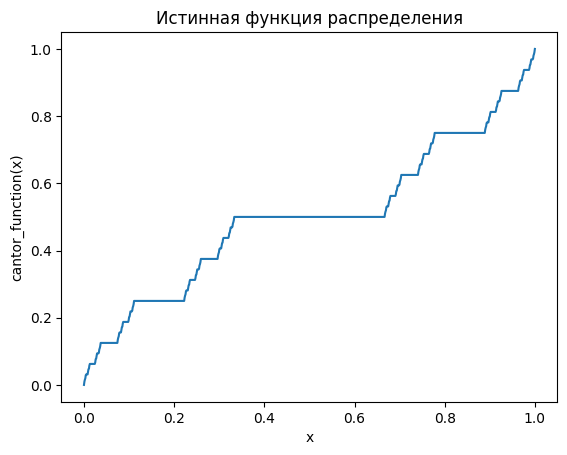

In [147]:
N = 1000
X = np.linspace(0, 1, N)
Y = np.zeros((N, 1))
for i in range(N):
    Y[i] = cantor_function(X[i])
plt.plot(X, Y)
plt.xlabel("x")
plt.ylabel("cantor_function(x)")
plt.title("Истинная функция распределения")
plt.show()

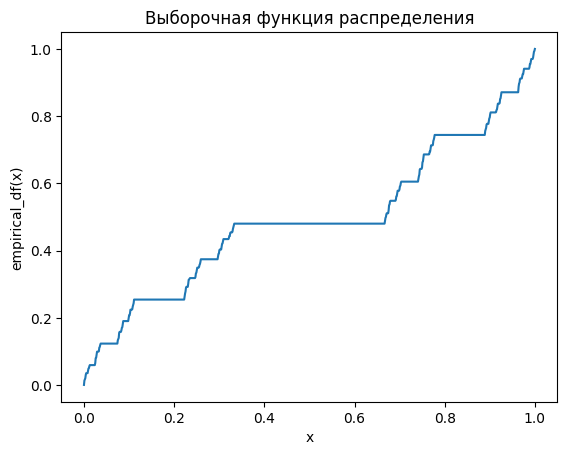

In [148]:
N = 1000
X = np.linspace(0, 1, N)
Y = np.zeros((N, 1))
sample = get_cantor(N)
for i in range(N):
    Y[i] = empirical_df(sample, X[i])
plt.plot(X, Y)
plt.xlabel("x")
plt.ylabel("empirical_df(x)")
plt.title("Выборочная функция распределения")
plt.show()

In [149]:
N = 1000 # размер выборки
sample = get_cantor(N)
Dn = 0
for i in range(N):
    diff = abs(empirical_df(sample, sample[i]) - cantor_function(sample[i]))
    if diff > Dn:
        Dn = diff
p_value = 1 - kolmogorov_df(np.sqrt(N) * Dn)
print(p_value)

0.3404479598101541


Таким образом, по критерию Колмогорова нулевую гипотезу можно считать верной.

## Проверка по критерию Смирнова

Будем проверять симметричность относительно $\frac{1}{2}$ ($X$ и $1 - X$ распределены одинаково) и свойство самоподобия относитьельно деления на 3 (условное распределение $Y$ при условии $Y \in [0, \frac{1}{3}]$ совпадает с распределением $\frac{Y}{3}$). Для этого используем критерий Смирнова, который используется для проверки гипотезы о принадлежности двух независимых выборок одному закону распределения. Пусть $F_{1, n},\, F_{2, m}$ --- выборочные функции распределения, построенные по незавимым выборкам объема $n$ и $m$, $D_{n, m} = \sup_x \lvert F_{1, n} - F_{2, m} \rvert$ Критерий смирнова гласит, что если статистика $\sqrt{\frac{nm}{n + m}}D_{n, m}$ превышает квантиль распределения Колмогорова $K_{\alpha}$ для заданного уровня значимости $\alpha$, то нулевая гипотеза $H_0$ об однородности выборок отвергается. Иначе она принимается на уровне $\alpha$. Выберем $\alpha = 0.05$. Возьмем одинаковый размер выборок N, посчитаем статистику и найдем значение функции распределения Колмогорова:

In [150]:
N = 10000

sample1 = get_cantor(N)
sample2 = 1 - get_cantor(N)
Dn = 0
for i in range(N):
    diff = abs(empirical_df(sample1, sample1[i]) - empirical_df(sample2, sample1[i]))
    if diff > Dn:
        Dn = diff
for i in range(N):
    diff = abs(empirical_df(sample1, sample2[i]) - empirical_df(sample2, sample2[i]))
    if diff > Dn:
        Dn = diff
p_value = 1 - kolmogorov_df(np.sqrt(N/2) * Dn)
print(p_value)

0.4358347905220322


Таким образом, по критерию Смирнова нулевую гипотезу можно считать верной.

## Рассчет матожидания и дисперсии

Посчитаем теоретические и эмпирические значения матожидания и дисперсии. Используем то, что случайная величина, имеющая функцию распределения Кантора, представима в виде
$$X = \sum_{n = 1}^\infty \alpha_i\frac{2}{3^n},$$
где $\alpha_i$ имеют распределение Бернулли с параметром 0.5. Тогда
$$\mathbb{E}X = \mathbb{E}\sum_{n = 1}^\infty \alpha_i\frac{2}{3^n} = \sum_{n = 1}^\infty \frac{2}{3^n}\mathbb{E}\alpha_i = \sum_{n = 1}^\infty \frac{1}{3^n} = \frac{1}{3}\frac{1}{1-\frac{1}{3}} = \frac{1}{2}$$
$$\mathbb{D}X = \mathbb{D}\sum_{n = 1}^\infty \alpha_i\frac{2}{3^n} = \sum_{n = 1}^\infty\frac{4}{9^n}\mathbb{D}\alpha_i = \sum_{n = 1}^\infty\frac{1}{9^n} = \frac{1}{9}\frac{1}{1-\frac{1}{9}} = \frac{1}{8}$$

In [151]:
N = 10000
sample = get_cantor(N)
E_empirical = sum(sample) / N
D_empirical = sum((sample - E_empirical) ** 2) / N
print("Выборочное матожидание:", E_empirical)
print("Выборочная дисперсия:", D_empirical)

Выборочное матожидание: 0.4976795755081697
Выборочная дисперсия: 0.1268198023022556


Видим, что выборочные значения близки к теоретическим. Проиллюстрируем сходимость эмпирических значений к теоретическим при стремлении размера выборки к бесконечности:

In [152]:
N = 100 # Число точек на графике
step = 10
size = step
X = np.arange(1,N+1) * step
E_empirical = np.zeros((N, 1))
D_empirical = np.zeros((N, 1))
for i in range(N):
    sample = get_cantor(size)
    E_empirical[i] = sum(sample) / size
    D_empirical[i] = sum((sample - E_empirical[i]) ** 2) / size
    size += step

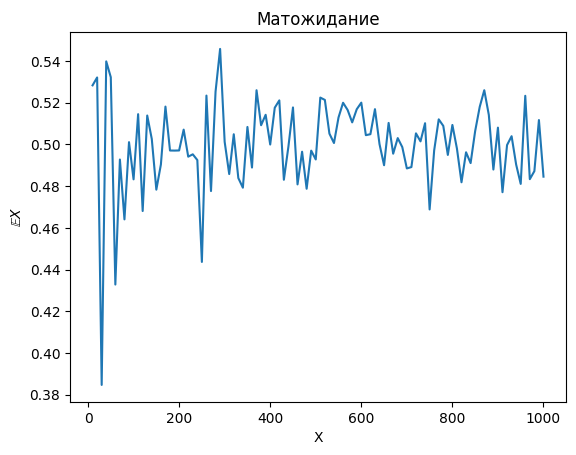

In [153]:
plt.plot(X, E_empirical)
plt.xlabel("X")
plt.ylabel("$\mathbb{E}X$")
plt.title("Матожидание")
plt.show()

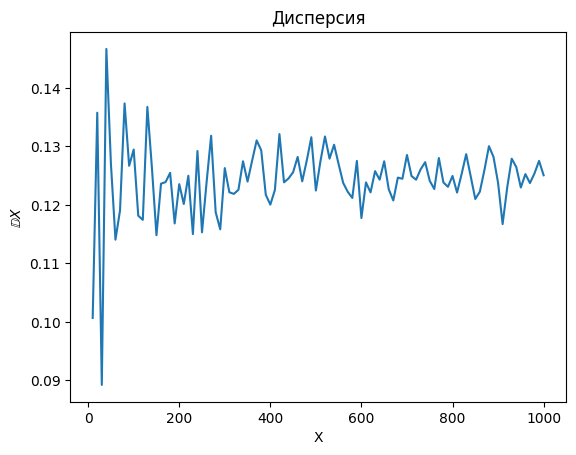

In [154]:
plt.plot(X, D_empirical)
plt.xlabel("X")
plt.ylabel("$\mathbb{D}X$")
plt.title("Дисперсия")
plt.show()

Видно, что обе величины сходятся к теоретическому значению

# Задание 3

## Датчик экспоненциального распределения

Датчик экспоненциального распределения был получен в задаче 1 путем обращения функции распределения.

In [155]:
def get_exponential(l, d):
    if isinstance(d, (int, np.integer)):
        d = (d,)
    if l < 0:
        print("Некорректные параметры")
        return;
    return -(1/l)*np.log(1 - np.random.rand(*d))

In [156]:
def interactive_exponential(l=1.0, sample_size=1000, max_x=5):
    """
    Интерактивная визуализация экспоненциального распределения

    Параметры:
    - l: параметр распределения (λ > 0)
    - sample_size: размер выборки
    - max_x: максимальное значение для отображения
    """
    # Генерация данных
    samples = get_exponential(l=l, d=sample_size)

    # Теоретическое распределение
    x = np.linspace(0, max_x, 500)
    probs = l * np.exp(-l * x)

    # Настройка графика
    plt.figure(figsize=(12, 6))

    # Гистограмма выборки
    plt.hist(samples, bins=50, density=True,
             alpha=0.7, color='skyblue',
             edgecolor='black', label='Выборка',
             range=(0, max_x))

    # Теоретическое распределение
    plt.plot(x, probs, 'r-', linewidth=2, label=f'Теория (λ={l:.2f})')

    # Оформление
    plt.title(f'Экспоненциальное распределение (λ={l:.2f})')
    plt.xlabel('Значение')
    plt.ylabel('Плотность вероятности')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.xlim(0, max_x)
    plt.ylim(0, l * 1.2)
    plt.show()

# Интерактивный интерфейс
interact(
    interactive_exponential,
    l=FloatSlider(min=0.1, max=5.0, step=0.1, value=1.0, description='λ:'),
    sample_size=IntSlider(min=100, max=10000, step=100, value=1000, description='Размер выборки:'),
    max_x=FloatSlider(min=1.0, max=10.0, step=0.5, value=5.0, description='Макс. значение:')
)

interactive(children=(FloatSlider(value=1.0, description='λ:', max=5.0, min=0.1), IntSlider(value=1000, descri…

<function __main__.interactive_exponential(l=1.0, sample_size=1000, max_x=5)>

Распределение дискретной случайной величины X обладает свойством отсутствия памяти, если $(X > t + \tau |X \ge \tau) = (X > t)\ \forall t, \tau \in \mathbb{Z},\, t > 0$.
$$\mathbb{P}(X > t + \tau |X \ge \tau) = \frac{\mathbb{P}(X > t + \tau,\, X \ge \tau)}{\mathbb{P}(X \ge \tau)} = \frac{\mathbb{P}(X > t + \tau)}{\mathbb{P}(X \ge \tau)} = \frac{e^{-\lambda(t + \tau)}}{e^{-\lambda \tau}} = e^{-\lambda t} = \mathbb{P}(X > t)$$

## Распределение минимума

Пусть $X_1, \dots, X_n$ --- независимые экспоненциально распределенные случайные величины с параметрами $(\lambda_1, \dots, \lambda_n)$. Найдем распределение случайной величины $Y = \min(X_1, \dots, X_n)$. Учитывая, что $\mathbb{P}(X > t) = e^{-\lambda t}$, получим:
$$\mathbb{P}(\min(X_1, \dots, X_n) > t) = \mathbb{P}(X_1 > t, \dots, X_n > t) = \prod_{k = 1}^n\mathbb{P}(X_k > t) = \prod_{k = 1}^n e^{-\lambda_k t} = e^{-(\lambda_1 + \ldots + \lambda_n) t}$$
Таким образом, полученная случайная величина имеет экспоненциальное распределение с параметром $\lambda = \lambda_1 + \ldots + \lambda_n$

## Датчик пуассоновского распределения через экспоненциальное

Пуассоновское распределение имеет функцию вероятности $\mathbb{P}(Y = k) = \frac{\lambda^k}{k!}e^{-\lambda}$. Будем использовать пуассоновский случайный процесс $N(t) \sim Pois(\lambda t)$. Для него можно определить случайную величину $\tau$, равную времени между событиями, то есть изменениями значения $N(t)$. Известно, что $\tau \sim Exp(\lambda)$. При $t = 1\ N(1) \sim Pois(\lambda)$. Будем генерировать случайные величины $\tau$ и суммировать их до того, пока сумма не превысит 1. Посчитав число слагаемых, получим число событий за единицу времени, то есть реализацию пуассоновской случайной величины. При этом слагаемое, после которого сумма превысила 1, учитывать не нужно, так как соответствующее событие произошло уже позже $t = 1$

In [157]:
def get_poisson_exp(l, d):
    if l < 0:
        print("Некорректные параметры")
        return;
    if isinstance(d, int):
        d = (d,)
    X = np.zeros(d, dtype=int)
    with np.nditer(X, op_flags=['readwrite']) as it:
        for x in it:
            S = get_exponential(l, 1)
            while (S < 1):
                x += 1
                S += get_exponential(l, 1)
    return X

In [158]:
def interactive_poisson_exp(l=1.0, sample_size=1000, max_k=10):
    """
    Интерактивная визуализация пуассоновского распределения

    Параметры:
    - l: параметр распределения (λ > 0)
    - sample_size: размер выборки
    - max_k: максимальное значение для отображения
    """
    # Генерация данных
    samples = get_poisson_exp(l=l, d=sample_size)

    # Теоретическое распределение
    k = np.arange(0, max_k + 1)
    probs = np.exp(-l) * (l**k) / np.array([math.factorial(k_i) for k_i in k])

    # Настройка графика
    plt.figure(figsize=(12, 6))

    # Гистограмма выборки
    plt.hist(samples, bins=np.arange(-0.5, max_k + 1.5, 1),
             density=True, alpha=0.7, color='skyblue',
             edgecolor='black', label='Выборка')

    # Теоретическое распределение
    plt.scatter(k, probs, color='red', s=50, zorder=3, label='Теория')
    plt.plot(k, probs, 'r--', alpha=0.5)

    # Оформление
    plt.title(f'Пуассоновское распределение (λ={l:.2f})')
    plt.xlabel('Количество событий')
    plt.ylabel('Вероятность')
    plt.xticks(np.arange(0, max_k + 1, max(1, max_k//5)))
    plt.legend()
    plt.grid(alpha=0.3)
    plt.xlim(-0.5, max_k + 0.5)
    plt.ylim(0, min(1, max(probs)*1.2))
    plt.show()

# Интерактивный интерфейс
interact(
    interactive_poisson_exp,
    l=FloatSlider(min=0.1, max=10.0, step=0.1, value=1.0, description='λ:'),
    sample_size=IntSlider(min=100, max=10000, step=100, value=1000, description='Размер выборки:'),
    max_k=IntSlider(min=5, max=50, step=1, value=10, description='Макс. значение:')
)

interactive(children=(FloatSlider(value=1.0, description='λ:', max=10.0, min=0.1), IntSlider(value=1000, descr…

<function __main__.interactive_poisson_exp(l=1.0, sample_size=1000, max_k=10)>

## Датчик пуассоновского распределения через биномиальное

Биномиальное распределение с параметрами $n,\, p$ имеет функцию вероятности $\mathbb{P}(X = k) = C_n^kp^k(1-p)^{n - k}$. Положим $pn = \lambda = const$, то есть $p = \frac{\lambda}{n}$. При $n \gg k$ верно $C_n^k \approx \frac{n^k}{k!}$, $(1 - p)^{n - k} = \left(1 - \frac{\lambda}{n}\right)^{n - k} \rightarrow e^{-\lambda}$. Тогда при $n \gg k$ имеем приближенное равенство:
$$\mathbb{P}(X = k) \approx \frac{n^k}{k!}p^ke^{-\lambda} = \frac{\lambda^k}{k!}e^{-\lambda} \sim Pois(\lambda)$$

In [159]:
def get_poisson_bin(l, d):
    if l < 0:
        print("Некорректные параметры")
        return;
    if isinstance(d, int):
        d = (d,)
    n = 1000
    return get_binomial(l/n, n, d)

In [160]:
def interactive_poisson_bin(l=1.0, sample_size=1000, max_k=10):
    """
    Интерактивная визуализация пуассоновского распределения

    Параметры:
    - l: параметр распределения (λ > 0)
    - sample_size: размер выборки
    - max_k: максимальное значение для отображения
    """
    # Генерация данных
    samples = get_poisson_bin(l=l, d=sample_size)

    # Теоретическое распределение
    k = np.arange(0, max_k + 1)
    probs = np.exp(-l) * (l**k) / np.array([math.factorial(k_i) for k_i in k])

    # Настройка графика
    plt.figure(figsize=(12, 6))

    # Гистограмма выборки
    plt.hist(samples, bins=np.arange(-0.5, max_k + 1.5, 1),
             density=True, alpha=0.7, color='skyblue',
             edgecolor='black', label='Выборка')

    # Теоретическое распределение
    plt.scatter(k, probs, color='red', s=50, zorder=3, label='Теория')
    plt.plot(k, probs, 'r--', alpha=0.5)

    # Оформление
    plt.title(f'Пуассоновское распределение (λ={l:.2f})')
    plt.xlabel('Количество событий')
    plt.ylabel('Вероятность')
    plt.xticks(np.arange(0, max_k + 1, max(1, max_k//5)))
    plt.legend()
    plt.grid(alpha=0.3)
    plt.xlim(-0.5, max_k + 0.5)
    plt.ylim(0, min(1, max(probs)*1.2))
    plt.show()

# Интерактивный интерфейс
interact(
    interactive_poisson_bin,
    l=FloatSlider(min=0.1, max=10.0, step=0.1, value=1.0, description='λ:'),
    sample_size=IntSlider(min=100, max=10000, step=100, value=1000, description='Размер выборки:'),
    max_k=IntSlider(min=5, max=50, step=1, value=10, description='Макс. значение:')
)

interactive(children=(FloatSlider(value=1.0, description='λ:', max=10.0, min=0.1), IntSlider(value=1000, descr…

<function __main__.interactive_poisson_bin(l=1.0, sample_size=1000, max_k=10)>

Проверим правильность при помощи критерия согласия Пирсона. В нем используется статистика хи-квадрат:
$$\chi^2 = n \sum_{i = 0}^k \frac{(\frac{n_i}{n} - \mathbb{P}_i(X))^2}{\mathbb{P}_i(X)},$$
где $n_i$ --- число значений, равных $i$, $\mathbb{P}_i(X) = \mathbb{P}(X = i)$ при $i = \overline{0,k-1}$; $n_k$ --- число значений, больших либо равных $k$, $\mathbb{P}_k(X) = \mathbb{P}(X \ge k)$. Зафиксируем уровень значимости $\alpha = 0.05$. Нулевая гипотеза о том, что выборка порождена пуассоновским распределением принимается, если значение функции распределения $\chi^2_{k-1}$ на статистике $\chi_2$ больше уровня значимости, иначе она отвергается. k выбирается так, чтобы при каждом значении $i < k$ было достаточно элементов выборки, равных $i$ (>5) (другой вариант --- выбирать интервалы, на которых достаточно значений).

In [161]:
k = 10
N = 1000
l = 2
sample = get_poisson_bin(l, N)
chi_2 = 0
P = np.exp(-l)
P_sum = 0
for i in range(k):
    P_sum += P
    chi_2 += (np.count_nonzero(sample == i)/N - P)**2 / P
    P = P * l / (i + 1)
chi_2 += (np.count_nonzero(sample >= k)/N - (1 - P_sum))**2 / (1 - P_sum) ## хвост
chi_2 *= N
print(scipy.stats.chi2.cdf(chi_2, k-1))

0.9945822832598581


Таким образом, нулевая гипотеза принимается.

## Датчик стандартного нормального распределения

Воспользуемся преобразованием Бокса-Мюллера. Пусть $r$ и $\varphi$ --- независимые равномерно распределенные на отрезке [0, 1]. Тогда случайные величины
$$z_0 = \cos(2\pi \varphi)\sqrt{-2\ln r},\, z_1 = \sin(2\pi \varphi)\sqrt{-2\ln r}$$
независимы и имеют стандартное нормальное распределение. Нам понадобится только одна из них.

In [162]:
def get_standart_normal(d):
    if isinstance(d, (int, np.integer)):
        d = (d,)
    r = np.random.rand(*d)
    phi = np.random.rand(*d)
    return np.cos(2*np.pi*phi) * np.sqrt(-2*np.log(r))

In [163]:
def interactive_standard_normal(sample_size=1000, bins=30, x_range=4.0):
    """
    Интерактивная визуализация стандартного нормального распределения

    Параметры:
    - sample_size: размер выборки
    - bins: количество столбцов гистограммы
    - x_range: диапазон отображения по оси X (±x_range)
    """
    # Генерация данных
    samples = get_standart_normal(d=sample_size)

    # Теоретическое распределение
    x = np.linspace(-x_range, x_range, 500)
    probs = np.exp(-x**2/2) / np.sqrt(2*np.pi)

    # Настройка графика
    plt.figure(figsize=(12, 6))

    # Гистограмма выборки
    plt.hist(samples, bins=bins, density=True,
             range=(-x_range, x_range),
             alpha=0.7, color='skyblue',
             edgecolor='black', label='Выборка')

    # Теоретическое распределение
    plt.plot(x, probs, 'r-', linewidth=2, label='Теория N(0,1)')

    # Оформление
    plt.title('Стандартное нормальное распределение')
    plt.xlabel('Значение')
    plt.ylabel('Плотность вероятности')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.xlim(-x_range, x_range)
    plt.ylim(0, 0.45)
    plt.show()

# Интерактивный интерфейс
interact(
    interactive_standard_normal,
    sample_size=IntSlider(min=100, max=10000, step=100, value=1000, description='Размер выборки:'),
    bins=IntSlider(min=5, max=100, step=1, value=30, description='Число столбцов:'),
    x_range=FloatSlider(min=1.0, max=5.0, step=0.5, value=4.0, description='Диапазон (±):')
)

interactive(children=(IntSlider(value=1000, description='Размер выборки:', max=10000, min=100, step=100), IntS…

<function __main__.interactive_standard_normal(sample_size=1000, bins=30, x_range=4.0)>

Проверим, что матожидание равно 0, при помощи критерия Стьюдента. Зафиксируем уровень значимости \alpha = 0.05. В критерии используется следующая статистика:
$$t = \frac{\overline X - m}{s_X/\sqrt n},$$
где $\overline X$ --- выборочное матожидание, $s_X$ --- несмещенное стандартное отклонение, $m = 0$ --- теоретическое значение матожидания. Рассматривается функция распределения Стьюдента.

В данном случае, в отличие от предыдущих, критерий является двусторонним, то есть надо проверять критические области с обеих сторон. Поэтому в данном случае берется минимум из вероятности попасть вправо или влево от статистики (и умножается на 2, т. к. вероятность попасть в каждую критическую область равна $\alpha/2$).

In [164]:
N = 10000
sample = get_standart_normal(N)
E = sum(sample) / N
s = np.sqrt(sum((sample - E)**2)/(N - 1))
m = 0
t = (E - m) / (s/np.sqrt(N))
p_value = 2 * min(1 - scipy.stats.t.cdf(t, N - 1), scipy.stats.t.cdf(t, N - 1))
print(p_value)

0.19402568532208453


Таким образом, гипотезу можно считать верной.

Проверим, что дисперсии двух выборок равны, при помощи критерия Фишера. Зафиксируем уровень значимости \alpha = 0.05. В критерии используется следующая статистика:
$$F = \frac{s^2_X}{s^2_Y},$$
где $s^2_X, s^2_Y$ --- выборочные дисперсии. Рассматривается функция распределения Фишера. Данный критерий также является двусторонним.

In [165]:
N = 10000
sample1 = get_standart_normal(N)
E1 = sum(sample1) / N
s1 = sum((sample1 - E1)**2)/N
sample2 = get_standart_normal(N)
E2 = sum(sample2) / N
s2 = sum((sample2 - E2)**2)/N
F = s1/s2
p_value = 2 * min(1 - scipy.stats.f.cdf(F, N - 1, N - 1), scipy.stats.f.cdf(F, N - 1, N - 1))
print(p_value)

0.36299541131864055


Таким образом, гипотезу можно считать верной.

# Задание 4

##Датчик распределения Коши

Распределение Коши $C(x_0, \gamma)$ с параметрами $x_0 \in \mathbb R$ и $\gamma > 0$ имеет следующую функцию распределения:
$$
    F_X(x) = \frac{1}{\pi}\arctan(\frac{x - x_0}{\gamma}) + \frac{1}{2}
$$
Воспользуемся тем, что если $U \sim \mathcal U[0, 1]$, то $X = x_0 + \gamma\tan\left(\pi\left(U - \frac{1}{2}\right)\right) \sim C(x_0, \gamma)$

In [166]:
def get_cauchy(x0, gamma, d):
    if gamma <= 0:
        print("Некорректные параметры")
        return;
    if isinstance(d, int):
        d = (d,)
    return x0 + gamma*np.tan(np.pi*(np.random.rand(*d) - 1/2))

In [167]:
def interactive_cauchy(x0=0.0, gamma=1.0, sample_size=1000, x_range=5.0):
    """
    Интерактивная визуализация распределения Коши

    Параметры:
    - x0: параметр сдвига (медиана)
    - gamma: параметр масштаба
    - sample_size: размер выборки
    - x_range: диапазон отображения по оси X (±x_range)
    """
    # Генерация данных
    samples = get_cauchy(x0=x0, gamma=gamma, d=sample_size)

    # Теоретическое распределение
    x = np.linspace(-x_range, x_range, 1000)
    probs = 1 / (np.pi * gamma * (1 + ((x - x0)/gamma)**2))

    # Настройка графика
    plt.figure(figsize=(12, 6))

    # Гистограмма выборки (логарифмическая шкала для y)
    plt.hist(samples, bins=100, density=True,
             range=(-x_range, x_range),
             alpha=0.7, color='skyblue',
             edgecolor='black', label='Выборка')

    # Теоретическое распределение
    plt.plot(x, probs, 'r-', linewidth=2, label=f'Теория (x0={x0}, γ={gamma})')

    # Оформление
    plt.title('Распределение Коши')
    plt.xlabel('Значение')
    plt.ylabel('Плотность вероятности')
    plt.yscale('log')  # Логарифмическая шкала для y
    plt.legend()
    plt.grid(alpha=0.3)
    plt.xlim(-x_range, x_range)
    plt.ylim(1e-4, 10)  # Диапазон для логарифмической шкалы
    plt.show()

# Интерактивный интерфейс
interact(
    interactive_cauchy,
    x0=FloatSlider(min=-5.0, max=5.0, step=0.1, value=0.0, description='x0 (сдвиг):'),
    gamma=FloatSlider(min=0.1, max=5.0, step=0.1, value=1.0, description='γ (масштаб):'),
    sample_size=IntSlider(min=100, max=10000, step=100, value=1000, description='Размер выборки:'),
    x_range=FloatSlider(min=1.0, max=20.0, step=1.0, value=5.0, description='Диапазон (±):')
)

interactive(children=(FloatSlider(value=0.0, description='x0 (сдвиг):', max=5.0, min=-5.0), FloatSlider(value=…

<function __main__.interactive_cauchy(x0=0.0, gamma=1.0, sample_size=1000, x_range=5.0)>

##Rejection sampling

Метод Фон Неймана, или же rejection sampling, это метод генерации выборки некоторого распределения. Будем генерировать выборку из стандартного нормального распределения при помощи распределения Коши. Для этого понадобятся их плотности. Плотность стандартного нормального распределения:
$$
    f(x) = \frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}.
$$
Плотность стандартного распределения Коши ($x_0 = 0, \gamma = 1$):
$$
    g(x) = \frac{1}{\pi} \frac{1}{x^2 + 1}.
$$
Для метода Фон Неймана понадобится найти константу $M$, для которой выполнено: $\frac{f(x)}{Mg(x)} \le 1\ \forall x \in \mathbb R$. Будем искать супремум отношения $r(x) = \frac{f(x)}{g(x)}$ (Чем меньше константа, тем быстрее работает метод, так что оптимальнее всего выбрать минимальное значение):
$$r(x) = \frac{f(x)}{g(x)} = \sqrt\frac{\pi}{2}(x^2 + 1)e^{-\frac{x^2}{2}}$$
$$r'(x) = \sqrt\frac{\pi}{2}\left(xe^{\frac{-x^2}{2}} - (x^2 + 1)\frac{x^2}{2}xe^{-\frac{x^2}{2}}\right) = \sqrt\frac{\pi}{2}xe^{-\frac{x^2}{2}}\frac{1}{2}\left(2 - x^4 - x^2\right) = 0 \Rightarrow x = 0,\, x = \pm 1.$$
$$r(0) = \sqrt\frac{\pi}{2},\, r(\pm 1) = \sqrt\frac{2\pi}{e}. \sqrt\frac{2\pi}{e} > \sqrt\frac{\pi}{2} \Rightarrow M = \sqrt\frac{2\pi}{e}.$$

In [168]:
def standart_normal_pdf(x):
    return (1/np.sqrt(2*np.pi))*np.exp(-x**2/2)

def standart_cauchy_pdf(x):
    return 1 / np.pi / (x**2 + 1)

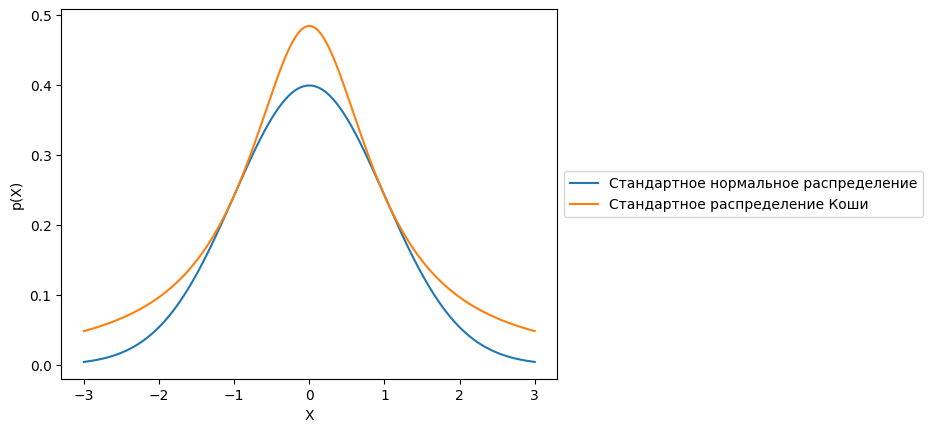

In [169]:
N = 1000
X = np.linspace(-3, 3, N)
plt.plot(X, standart_normal_pdf(X))
plt.plot(X, np.sqrt(2*np.pi/np.e)*standart_cauchy_pdf(X))
plt.xlabel("X")
plt.ylabel("p(X)")
plt.legend(["Стандартное нормальное распределение", "Стандартное распределение Коши"], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Смысл метода в том, что мы генерируем значение из известного распределения $x$ и принимаем его в выборку целевого распределения с вероятностью $\frac{f(x)}{Mg(x)}$. Обоснуем применимость метода. Рассмотрим плотность вероятности при условии, что мы приняли значение:
$$
    p(x|A) = \frac{\mathbb{P}(A|x)p(x)}{\mathbb{P}(A)} = \frac{\frac{f(x)}{Mg(x)}g(x)}{\mathbb{P}(A)}
$$
$$
    \mathbb P(A) = \int_{-\infty}^{+\infty} \frac{f(x)}{Mg(x)} g(x) \mathrm dx = \int_{-\infty}^{+\infty} \frac{f(x)}{M} \mathrm dx = \frac{1}{M}
$$
$$
    p(x|A) = \frac{\frac{f(x)}{Mg(x)}g(x)}{\frac{1}{M}} = f(x)
$$
Таким образом, мы получаем нужную плотность распределения.

In [170]:
def get_standart_normal_rs(d):
    if isinstance(d, (int, np.integer)):
        d = (d,)
    N = np.prod(d)
    F = []
    while len(F) < N:
        G = get_cauchy(0, 1, d)
        P = standart_normal_pdf(G) / (np.sqrt(2*np.pi/np.e)*standart_cauchy_pdf(G))
        F.extend(G[np.random.rand(*d) < P])
        #print(len(F))
    return np.array(F)[0:N].reshape(d)

In [171]:
def interactive_standard_normal_rs(sample_size=1000, bins=30, x_range=4.0):
    """
    Интерактивная визуализация стандартного нормального распределения

    Параметры:
    - sample_size: размер выборки
    - bins: количество столбцов гистограммы
    - x_range: диапазон отображения по оси X (±x_range)
    """
    # Генерация данных
    samples = get_standart_normal_rs(d=sample_size)

    # Теоретическое распределение
    x = np.linspace(-x_range, x_range, 500)
    probs = np.exp(-x**2/2) / np.sqrt(2*np.pi)

    # Настройка графика
    plt.figure(figsize=(12, 6))

    # Гистограмма выборки
    plt.hist(samples, bins=bins, density=True,
             range=(-x_range, x_range),
             alpha=0.7, color='skyblue',
             edgecolor='black', label='Выборка')

    # Теоретическое распределение
    plt.plot(x, probs, 'r-', linewidth=2, label='Теория N(0,1)')

    # Оформление
    plt.title('Стандартное нормальное распределение')
    plt.xlabel('Значение')
    plt.ylabel('Плотность вероятности')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.xlim(-x_range, x_range)
    plt.ylim(0, 0.45)
    plt.show()

# Интерактивный интерфейс
interact(
    interactive_standard_normal_rs,
    sample_size=IntSlider(min=100, max=10000, step=100, value=1000, description='Размер выборки:'),
    bins=IntSlider(min=5, max=100, step=1, value=30, description='Число столбцов:'),
    x_range=FloatSlider(min=1.0, max=5.0, step=0.5, value=4.0, description='Диапазон (±):')
)

interactive(children=(IntSlider(value=1000, description='Размер выборки:', max=10000, min=100, step=100), IntS…

<function __main__.interactive_standard_normal_rs(sample_size=1000, bins=30, x_range=4.0)>

Приверим корректность при помощи метода normal probability plot. Для этого отсортируем выборку и выведем ее на плоскость, где в качестве координаты y будем использовать теоретические квантили нормального распределения.

Любое нестандартное нормальное распределение можно представить в виде $\mu + \sigma \mathcal N(0, 1)$, то есть в виде линейного преобразования стандартного, поэтому график также будет линейным. Для других распределений квантили ведут себя по другому, поэтому график не будет линейным. Также графики не будут инвариантны относительно параметров масштаба и сдвига.

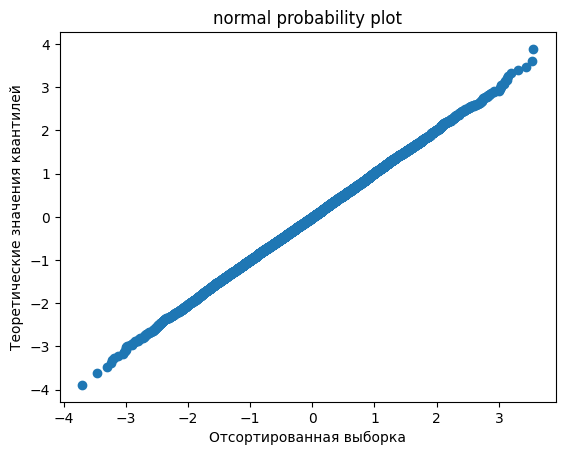

In [172]:
N = 10000
sample = sorted(get_standart_normal_rs(N))
p = (np.arange(N) + 0.5) / N
quantiles = scipy.stats.norm.ppf(p)
plt.scatter(sample, quantiles)
plt.xlabel("Отсортированная выборка")
plt.ylabel("Теоретические значения квантилей")
plt.title("normal probability plot")
plt.show()

## Сравнение скорости работы датчиков

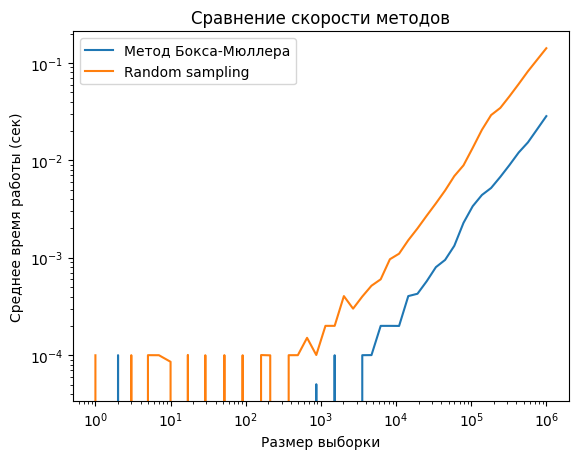

In [173]:
times = 10  # Количество повторений
Ns = np.round(np.logspace(0, 6, 50)).astype(int)

times1 = []
times2 = []

for N in Ns:
    time1 = 0
    for i in range(times):
        start = time.time()
        get_standart_normal(N)
        end = time.time()
        time1 += end - start
    times1.append(time1 / times)

    time2 = 0
    for i in range(times):
        start = time.time()
        get_standart_normal_rs(N)
        end = time.time()
        time2 += end - start
    times2.append(time2 / times)

plt.plot(Ns, times1)
plt.plot(Ns, times2)
plt.xlabel("Размер выборки")
plt.ylabel("Среднее время работы (сек)")
plt.title("Сравнение скорости методов")
plt.legend(["Метод Бокса-Мюллера", "Random sampling"], loc='upper left')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

Таким образом, метод Бокса-Мюллера на порядок быстрее, чем random sampling

# Задание 5

## ЗБЧ и ЦПТ

Рассмотрим независимые одинакого распределенные случайные величины: $X_i \sim \mathcal{N} (\mu, \sigma^2)$. Убедимся эмприрически в справедливости закона больших чисел (ЗБЧ) и центральной предельной теоремы (ЦПТ). Рассмотрим среднее $M_n = \frac{X_1 + \dots + X_n}{n}$. ЗБЧ гласит, что $M_n \xrightarrow[n \to \infty]{p} \mu$.

In [174]:
def get_normal(mu, sigma, d):
    if isinstance(d, (int, np.integer)):
        d = (d,)
    return mu + sigma * get_standart_normal(d)

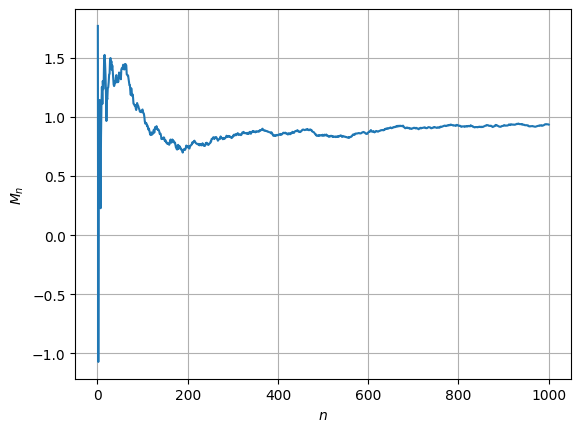

In [175]:
N = 1000
mu = 1
sigma = 2
sample = get_normal(mu, sigma, N)
S = np.cumsum(sample)
X = np.arange(1, N+1)
M = S / X

plt.plot(X, M)
plt.xlabel("$n$")
plt.ylabel("$M_n$")
plt.grid()
plt.show()

ЦПТ гласит, что $Y = \frac{S_n - \mu n}{\sigma \sqrt n} \xrightarrow[n \to \infty]{d} \mathcal{N}(0, 1)$, где $S_n = X_1 + \dots + X_n$. Сходимость по распределению означает, что распределение получившейся величины близко к целевому.

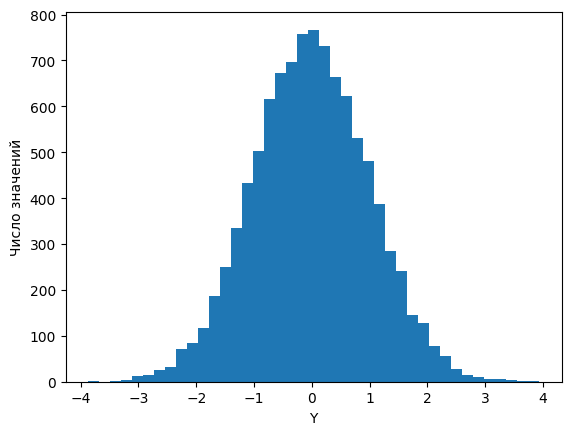

In [176]:
n = 100 # Число слагаемых в сумме
N = 10000 # Число моделирований суммы
mu = 1
sigma = 2

sample = []
for i in range(N):
    S = sum(get_normal(mu, sigma, n))
    sample.append((S - mu*n) / (sigma * np.sqrt(n)))
n_bins = 41
plt.hist(sample, bins = n_bins)
plt.xlabel("Y")
plt.ylabel("Число значений")
plt.show()

Видно, что распределение соответствует нормальному.

## Доверительные интервалы

Доверительным интервалом называется интервал, которому принадлежит неизвестный параметр с заданной вероятностью. Для нормального распределения рассмотрим симметричный доверительный интервал, то есть $\mathbb P(-\gamma < S < \gamma) = \alpha$. в данном случае требуется найти доверительный интервал для матожидания и дисперсии по выборке из нормального распределения $X_1, \dots, X_n$.

В случае матожидания рассмотрим случайную величину
$$
    T = \sqrt n \frac{M - \mu}{s},
$$
где $M = \frac{X_1 + \dots + X_n}{n}$ --- выборочное среднее, $s = \sqrt{\frac{\sum_{i = 1}^n(X_i - M)^2}{n-1}}$ --- несмещенное выборочное стандартное отклонение. Известно, что эта величина имеет распределение Стьюдента с $n - 1$ степенями свободы. Пусть $t_{\alpha, n-1}$ --- $\alpha$-квантиль распределения Стьюдента. Тогда в силу симметрии квантилей имеем:
$$
    \mathbb{P}(-t_{1-\frac{1-\alpha}{2},n-1} < T < t_{1-\frac{1-\alpha}{2},n-1}) = \alpha
$$
$$
    \mathbb{P}(-t_{1-\frac{1-\alpha}{2},n-1} < \sqrt n \frac{M - \mu}{s} < t_{1-\frac{1-\alpha}{2},n-1}) = \alpha
$$
$$
    \mathbb{P}(-t_{1-\frac{1-\alpha}{2},n-1}\frac{s}{\sqrt n} + M < \mu < t_{1-\frac{1-\alpha}{2},n-1}\frac{s}{\sqrt n} + M) = \alpha
$$
Таким образом, доверительный интервал имеет вид
$$
    [-t_{1-\frac{1-\alpha}{2},n-1}\frac{s}{\sqrt n} + M, t_{1-\frac{1-\alpha}{2},n-1}\frac{s}{\sqrt n} + M].
$$

В случае дисперсии рассмотрим случайную величину
$$
    H = \frac{(n - 1)s^2}{\sigma^2}.
$$
Известно, что она имеет распределение $\chi^2(n - 1)$. Имеем:
$$
    \mathbb{P}(\chi^2_{\frac{1-\alpha}{2},n-1} < H < \chi^2_{1-\frac{1-\alpha}{2},n-1}) = \alpha
$$
$$
    \mathbb{P}(\chi^2_{\frac{1-\alpha}{2},n-1} < \frac{(n - 1)s^2}{\sigma^2} < \chi^2_{1-\frac{1-\alpha}{2},n-1}) = \alpha
$$
$$
    \mathbb{P}(\frac{(n-1)s^2}{\chi^2_{1-\frac{1-\alpha}{2},n-1}} < \sigma^2 < \frac{(n-1)s^2}{\chi^2_{\frac{1-\alpha}{2},n-1}}) = \alpha
$$
Следовательно, доверительный интервал имеет вид
$$
    [\frac{(n-1)s^2}{\chi^2_{1-\frac{1-\alpha}{2},n-1}}, \frac{(n-1)s^2}{\chi^2_{\frac{1-\alpha}{2},n-1}}].
$$

Покажем эволюцию интервалов при росте объема выборки:

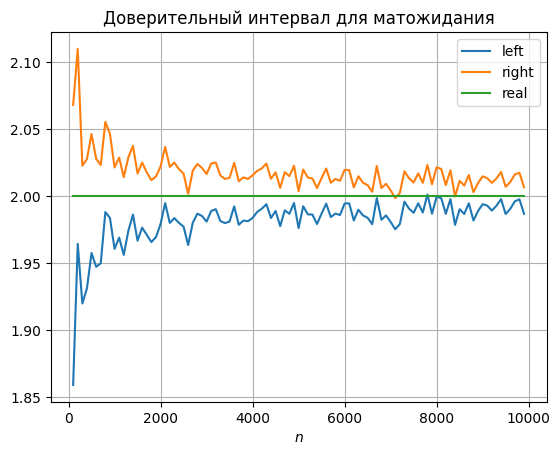

In [177]:
N = 10000
step = 100
Ns = np.arange(step, N, step).astype(int)
mu = 2
sigma = 0.5
alpha = 0.95
L = []
R = []
for n in Ns:
    sample = get_normal(mu, sigma, n)
    M = np.sum(sample) / n
    s = np.sqrt(np.sum((sample - M)**2)/(n-1))
    q = scipy.stats.t.ppf(1-(1-alpha)/2, n-1)
    L.append(-q*s/np.sqrt(n) + M)
    R.append(q*s/np.sqrt(n) + M)

plt.plot(Ns, L)
plt.plot(Ns, R)
plt.plot(Ns, np.ones(len(Ns))*mu)
plt.legend(["left", "right", "real"])
plt.xlabel("$n$")
plt.title("Доверительный интервал для матожидания")
plt.grid()
plt.show()

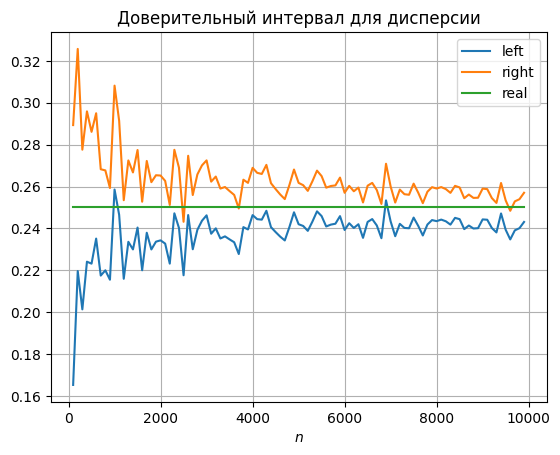

In [178]:
N = 10000
step = 100
Ns = np.arange(step, N, step).astype(int)
mu = 2
sigma = 0.5
alpha = 0.95
L = []
R = []
for n in Ns:
    sample = get_normal(mu, sigma, n)
    M = np.sum(sample) / n
    s2 = np.sum((sample - M)**2)/(n-1)
    L.append((n-1)*s2/scipy.stats.chi2.ppf(1-(1-alpha)/2, n-1))
    R.append((n-1)*s2/scipy.stats.chi2.ppf((1-alpha)/2, n-1))


plt.plot(Ns, L)
plt.plot(Ns, R)
plt.plot(Ns, np.ones(len(Ns))*sigma**2)
plt.legend(["left", "right", "real"])
plt.xlabel("$n$")
plt.title("Доверительный интервал для дисперсии")
plt.grid()
plt.show()

##Средние распределения Коши

Пусть $X_i \sim K(a, b)$ --- распределение Коши с параметром сдвига a и масштаба b. Изучим, как ведут себя средние $M_n = \frac{S_n}{n} = \frac{X_1 + \dots + X_n}{n}$. Посмотрим на их распределение при некотором большом $n$:

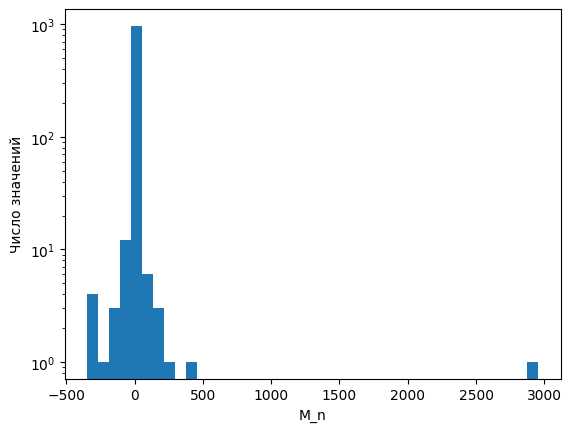

In [179]:
n = 100 # Число слагаемых в сумме
N = 1000 # Число моделирований суммы
a = 1
b = 2

sample = []
for i in range(N):
    sample.append(np.sum(get_cauchy(a, b, n))/n)
n_bins = 41
plt.hist(sample, bins = n_bins)
plt.xlabel("M_n")
plt.ylabel("Число значений")
ax = plt.gca()
ax.set_yscale('log')
plt.show()

Видим, что присутствуют сильные выбросы, то есть величина не сходится. Это вызвано тем, что у распределения Коши тяжелые хвосты. Покажем, что среднее имеет распределение Коши с теми же параметрами. Рассмотрим характеристическую функцию распределения Коши:
$$
    \varphi_X(x) = \mathbb E(e^{itX}) = e^{ita + b|t|}
$$
Тогда в силу независимости
$$
    \varphi_{M_n}(x) = \prod_{k = 1}^n \mathbb E(e^{it\frac{X_k}{n}}) = \left(e^{\frac{ita + b|t|}{n}}\right)^n = e^{ita + b|t|}
$$
Таким образом, среднее имеет то же распределение, что и слагаемые.

# Задание 6

Требуется вычислить следующий интеграл:
$$
    I = \int_{-\infty}^{+\infty} \int_{-\infty}^{+\infty} \dots \int_{-\infty}^{+\infty} \frac{e^{-\left(x_1^2 + \dots + x_{10}^2 + \frac{1}{2^7\cdot x_1^2 \cdot \dots \cdot x_{10}^2}\right)}}{x_1^2 \cdot \dots \cdot x_{10}^2} \mathrm{d}x_1 \mathrm{d} x_2 \dots \mathrm{d} x_{10}
$$

## Метод Монте Карло

Метод Монте Карло заключается в том, что некий случайный процесс многократно моделируется, а потом на его основе высчитываются нужные характеристики. В случае интегрирования стандартный метод заключается в следующем:

Пусть нужно вычислить интеграл

$$
    \int_a^b f(x) \mathrm{d}x
$$
Рассмотрим случайную величину $u$, равномерно распределенную на отрезке $[a, b]$. Тогда $f(u)$ --- тоже случайная величина, причем
$$
    \mathbb{E}f(u) = \int_a^b f(x) \varphi(x) \mathrm{d}x,
$$
где $\varphi(x) = \frac{1}{b-a}$ --- плотность случайной величины $u$. Таким образом,
$$
    \int_a^b f(x) \mathrm{d}x = (b - a) \mathbb{E}f(u),
$$
но матожидание $f(u)$ можно легко оценить, смоделировав эту случайную величину и посчитав выборочное среднее.

Применим похожую идею для данной задачи. Пусть случайные величины $X_i,\, i = \overline{1, 10}$ имеют нормальное распределение. Их плотность распределения имеет вид
$$
    p_i(x_i) = \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{1}{2}\left(\frac{x_i - \mu}{\sigma}\right)^2},
$$
где $\mu$ --- матожидание, $\sigma^2$ --- дисперсия. Взяв $\mu = 0$ и $\sigma = \frac{1}{\sqrt 2}$, имеем
$$
    p_i(x_i) = \frac{1}{\sqrt \pi}e^{-x_i^2}.
$$
Тогда вектор $X = (X_1, \dots, X_{10})$ имеет имеет плотность распределения
$$
    p(x) = \prod_{i = 1}^{10} p_i(x_i) = \frac{1}{\pi^5}e^{-(x_1^2 + \dots + x_{10}^2)},
$$
где $x = (x_1, \dots, x_{10})$. Пусть $y = \frac{1}{x_1^2 \cdot \dots \cdot x_{10}^2},\,f(x) = \pi^5 ye^{-\frac{y}{2^7}}$, тогда
$$
    I = \int_{\mathbb{R}^{10}} f(x)p(x)\mathrm{d}x = \mathbb{E}f(X).
$$
Таким образом, достаточно промоделировать нормальный вектор $X$ достаточное число раз, посчитать $f(X)$ и найти среднее $\overline X_n = \frac{1}{n}\sum_{k = 1}^n f(X_k)$ как приближение матожидания.

Оценим ошибку через неравенство Чебышёва:
$$
    \mathbb{P}(|\overline X_n - \mathbb E X| \ge \varepsilon) \le \frac{\mathbb{D} X}{n \varepsilon^2}.
$$
Для оценки дисперсии используем несмещенную выборочную дисперсию:
$$
    s^2_n = \frac{1}{n-1}\sum_{k = 1}^n (X_k - \overline X)^2.
$$
При достаточно больших $n\ (n \ge 100)$ эта оценка будет иметь высокую точность.
Таким образом,
$$
    \mathbb{P}(|\overline X_n - \mathbb E X| \ge \varepsilon) \le \frac{s^2_n}{n \varepsilon^2} = 1 - \alpha.
$$
Зафиксируем $\varepsilon = 1, n = 10^7$.

In [180]:
def f(x):
    y = 1 / np.prod(x, 0) ** 2
    return np.pi ** 5 * y * np.exp(-y / 2**7)

In [181]:
N = 10000000
eps = 1
M = 10
a = []
S = []
for i in range(M):
    normal_sample = scipy.stats.norm.rvs(loc=0, scale=1/np.sqrt(2), size=(10, N))
    sample = f(normal_sample)
    M = np.sum(sample) / N
    s2 = (1/(N - 1))*np.sum((sample - M)**2)
    a.append(1 - s2/(N*eps**2))
    S.append(np.sum(sample) / N)

In [182]:
df = pd.DataFrame({"Альфа": a, "Значение интеграла": S})
df

,Альфа,Значение интеграла
0,0.869426,125.404001
1,0.870231,124.808444
2,0.870650,124.371192
3,0.870158,124.753057
4,0.869981,124.943602
5,0.870029,124.859827
6,0.870913,124.361187
7,0.870246,124.860715
8,0.869978,125.026559
9,0.870611,124.605029


Здесь альфа --- вероятность вычисленного значения попасть в доверительный интервал $[I - \varepsilon, I + \varepsilon],\, \varepsilon = 1$.

## Метод квадратур

Воспользуемся методом прямоугольников. Для этого сделаем замену
$$
    x_i = \tan(x_i),\, \mathrm dx_i = \frac{\mathrm dy_i}{\cos^2y_i},\, i = \overline{1, 10}.
$$
Интеграл принимает вид
$$
    \int_{-\frac{\pi}{2}}^{\frac{\pi}{2}} \dots \int_{-\frac{\pi}{2}}^{\frac{\pi}{2}} \exp\left(-\sum_{i = 1}^{10} \tan^2 y_i - 2^{-7}\prod_{i = 1}^{10}\cot^2 y_i\right)\prod_{i = 1}^{10}\cot^2 y_i\prod_{i = 1}^{10}\frac{1}{\cos^2 y_i} \mathrm dy_1 \dots \mathrm dy_{10} =
$$
$$
     = \int_{-\frac{\pi}{2}}^{\frac{\pi}{2}} \dots \int_{-\frac{\pi}{2}}^{\frac{\pi}{2}} \exp\left(-\sum_{i = 1}^{10} \tan^2 y_i - 2^{-7}\prod_{i = 1}^{10}\cot^2 y_i\right)\prod_{i = 1}^{10}\frac{1}{\sin^2 y_i} \mathrm dy_1 \dots \mathrm dy_{10} =
$$
$$
    = \int_{[-\frac{\pi}{2}, \frac{\pi}{2}]^{10}}f(y)dy = 2^{10}\int_{[0, \frac{\pi}{2}]^{10}}f(y)dy,
$$
где
$$
    y = (y_1, \dots, y_{10}),\, f(y) = \exp\left(-\sum_{i = 1}^{10} \tan^2 y_i - 2^{-7}\prod_{i = 1}^{10}\cot^2 y_i\right)\prod_{i = 1}^{10}\frac{1}{\sin^2 y_i}.
$$
Будем пользоваться методом следних прямоугольников. Для вычисления интеграла составим разбиение отрезка $[0, \frac{\pi}{2}]$ на N частей и получим серединные точки: $T = \{\frac{h}{2}, \frac{h}{2} + h, \dots, \frac{h}{2} + (N-1)h\} = \{T_0, \dots, T_{N-1}\}$, где $h = \frac{\pi}{2 N}$. Возведем в 10 декартову степень для получения 10--мерной сетки. Итоговая формула для численного вычисления интеграла:
$$
    I = 2^{10}\sum_{x \in T^{10}}f(x)h^{10}.
$$

In [183]:
def f(x):
    return np.exp(-np.sum(np.tan(x)**2, -1) - 2**(-7)*np.prod(np.tan(x)**(-2), -1))*np.prod(np.sin(x)**(-2), -1)

def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

In [184]:
n = 10
N = 5
a = 0
b = np.pi/2
h = (b - a) / N
T = np.linspace(h/2, b - h/2, N)
X = cartesian_product(*((T,) * 10))

I = 2**10 * np.sum(f(X)) * h**10

In [185]:
print(I)

116.39025860063605


Можно существенно сократить вычисления, заметив, что функция не меняет значение при перестановке аргументов. Тогда интеграл можно записать как
$$
    I = \sum_{0 \le k_1 \le k_2 \le \dots \le k_{10} \le N-1} \frac{N!}{n_1!\cdot \dots \cdot n_{N}!} f(T_{k_1}, \dots, T_{k_{10}}),
$$
где $n_i, i = \overline{1, N}$ --- число индексов, равных $i - 1$.

In [186]:
def multinomial(lst):
    res, i = 1, sum(lst)
    i0 = lst.index(max(lst))
    for a in lst[:i0] + lst[i0+1:]:
        for j in range(1,a+1):
            res *= i
            res //= j
            i -= 1
    return res

def integrate_numerically(N):
    n = 10
    a = 0
    b = np.pi/2
    h = (b - a) / N
    T = np.linspace(h/2, b - h/2, N)
    ind = itertools.combinations_with_replacement(range(N), n)
    I = 0
    for i in ind:
        i = list(i)
        count = list(collections.Counter(i).values())
        count = count[:N] + [0]*(N - len(count))
        I += f(T[i])*multinomial(count)
    return 2**10*I*h**10

In [187]:
print(integrate_numerically(5))
print(integrate_numerically(12))

116.39025860063616
124.98912846401902


При $N = 5$ значение совпадает с предыдущим вычислением, но теперь удается посчитать интеграл с намного большей точностью.

Оценим погрешность. Разложим $f(\mathbf{x})$ в ряд Тейлора вокруг центра $\mathbf{c}$ гиперкуба:
$$
f(\mathbf{x}) \approx f(\mathbf{c}) + \sum_{k=1}^n \frac{\partial f}{\partial x_k} \bigg|_{\mathbf{c}} (x_k - c_k) + \frac{1}{2} \sum_{k,l=1}^n \frac{\partial^2 f}{\partial x_k \partial x_l} \bigg|_{\mathbf{c}} (x_k - c_k)(x_l - c_l) + \dots
$$
Интеграл от нечетных членов равен нулю в силу симметрии. Интегрирование квадратичных членов даёт вклад в погрешность:
$$
\text{Ошибка на 1 гиперкубе} \sim \frac{h^2}{24} \sum_{k=1}^n \frac{\partial^2 f}{\partial x_k^2} \bigg|_{\mathbf{c}} \cdot h^n.
$$

Если вторые производные ограничены $M$, то:
$$
E \sim N^n \cdot \frac{h^2}{24} \cdot M \cdot h^n = \frac{M}{24} \cdot (b-a)^n \cdot h^2.
$$
Проблема заключается в том, что число точек разбиения n--мерной сетки $N^n$ растет экспоненциаьно с ростом размерности. Для получения хорошей точности требуется уменшать шаг разбиения, но при этом число точек разбиения $N^n = \left(\frac{b - a}{h}\right)^n$ стремительно растет, поэтому вычисления с высокой точностью просто невозможны. Это явление называется проклятием размерности (curse of dimensionality).

# Задание 7

Требуется методами случайного поиска и имитации отжига найти минимальное значение функции $f$ на множестве $A = \{x_1, x_2: x_1^2 + x_2^2 \leqslant 1\}$, где

$$ f(x_1, x_2) = x_1^3 \sin(\frac{1}{x_1}) + 10 x_1 x_2^4 \cos(\frac{1}{x_2}),\quad x_1,x_2 \neq 0 $$

При $x_1 = 0$  или $x_2 = 0$ функция доопределяется по непрерывности (нулем).

Зададим данную функцию:

In [188]:
def f(x1, x2):
    if (x1 == 0 or x2 == 0):
        return 0
    else:
        return x1 ** 3 * np.sin(1/x1) + 10 * x1 * x2 ** 4 * np.cos(1/x2)

## Метод случайного поиска

В методе случайного поиска задается начальная точка $x$, после чего до выполнения критерия остановки повторяется следующее действие:

Выбирается случайная точка на окружности с центром в текущей точке. В классическом случае, рассматривающемся здесь, радиус окружности фиксирован. Если значение в новой точке меньше, чем в текущей, то текущая точка заменяется на новую, иначе точка не меняется.

В данном случае в качестве критерия остановки будет использоваться число итераций.

In [189]:
def random_search(f, r, R, n_iter):
    x1 = 0
    x2 = 0
    for i in range(n_iter):
        phi = np.random.rand() * 2 * np.pi
        y1 = x1 + r * np.cos(phi)
        y2 = x2 + r * np.sin(phi)
        #print(f(x1, x2), f(y1, y2))
        if (y1 ** 2 + y2 ** 2 < R ** 2 and (f(y1, y2) < f(x1, x2))):
            x1 = y1
            x2 = y2
            #print(x1, x2, f(x1, x2))
    return x1, x2

In [201]:
r = 0.1
R = 1
n_iter = 100000

for i in range(5):
    x1, x2 = random_search(f, r, R, n_iter)
    print(f"x1 = {x1}, x2 = {x2}, f(x1, x2) = {f(x1, x2)}")

x1 = -0.23707076463604612, x2 = 0.13573964297489483, f(x1, x2) = -0.012106095942843627
x1 = 0.33647277264276654, x2 = 0.4560450589359005, f(x1, x2) = -0.07836758879346986
x1 = 0.2438237194492065, x2 = 0.0669015730998255, f(x1, x2) = -0.011907592392956141
x1 = 0.27158841555020463, x2 = 0.5096522321059271, f(x1, x2) = -0.0801953615968157
x1 = 0.330125151235735, x2 = 0.47535446709309986, f(x1, x2) = -0.08159577750621344


In [191]:
r = 0.01
R = 1
n_iter = 100000

for i in range(5):
    x1, x2 = random_search(f, r, R, n_iter)
    print(f"x1 = {x1}, x2 = {x2}, f(x1, x2) = {f(x1, x2)}")

x1 = -0.042700754777144925, x2 = 0.038245298457255314, f(x1, x2) = -7.754477560983047e-05
x1 = 0.04268180587042561, x2 = -0.021904233969924407, f(x1, x2) = -7.708063296689961e-05
x1 = 0.04266689024042056, x2 = 0.004342680243148642, f(x1, x2) = -7.707175166310613e-05
x1 = 0.0426490984352325, x2 = -0.020748947695757032, f(x1, x2) = -7.710370625871938e-05
x1 = 0.042674879815343875, x2 = 0.004342971026790109, f(x1, x2) = -7.707194546979087e-05


In [192]:
r = 0.001
R = 1
n_iter = 100000

for i in range(5):
    x1, x2 = random_search(f, r, R, n_iter)
    print(f"x1 = {x1}, x2 = {x2}, f(x1, x2) = {f(x1, x2)}")

x1 = -0.0135527879377365, x2 = -0.0038966347550393188, f(x1, x2) = -2.4871854336586495e-06
x1 = 0.01355258443801065, x2 = -0.00023422812846527678, f(x1, x2) = -2.4871698813914173e-06
x1 = -0.013552465302102527, x2 = 0.0032332925766892567, f(x1, x2) = -2.487171990707244e-06
x1 = 0.013551557376344144, x2 = -0.005968415088326402, f(x1, x2) = -2.4872191472217077e-06
x1 = -0.013552233893525242, x2 = -0.004067213154034554, f(x1, x2) = -2.4871911341562216e-06


Как видно, при выборе слишком маленького радиуса сферы алгоритм попадает в локальный минимум (коих у это функции много), но становится более стабильным.

Провизуализируем путь алгоритма на каком-то примере

x1 = -0.013552462750151472, x2 = -0.001422660529008512, f(x1, x2) = -2.4871699285062198e-06


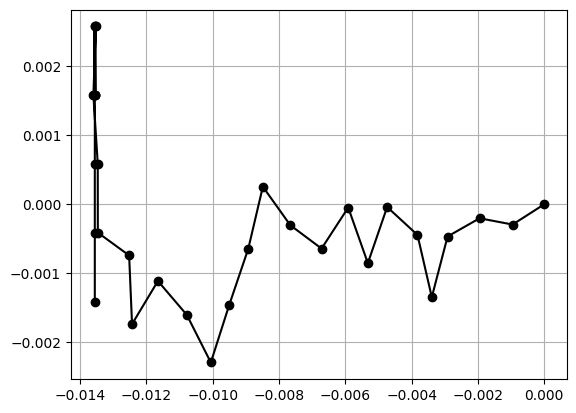

In [193]:
r = 0.001
R = 1
n_iter = 100000    
x1 = 0
x2 = 0
x1s = [0]
x2s = [0]
for i in range(n_iter):
    phi = np.random.rand() * 2 * np.pi
    y1 = x1 + r * np.cos(phi)
    y2 = x2 + r * np.sin(phi)
    if (y1 ** 2 + y2 ** 2 < R ** 2 and (f(y1, y2) < f(x1, x2))):
        x1 = y1
        x2 = y2
        x1s.append(x1)
        x2s.append(x2)
print(f"x1 = {x1}, x2 = {x2}, f(x1, x2) = {f(x1, x2)}")
plt.plot(x1s, x2s, 'ko-')
plt.grid(True)
plt.show()

## Метод имитации обжига

Название метода происходит от обжига в металлургии — это процесс, при котором металл постепенно охлаждатеся для изменения его физических свойств. Суть метода состоит в следующем:
1. Выбираем начальное приближение (состояние системы) и температуру T (достаточно большую)
2. На каждом шаге будем некоторым случайным способом выбирать соседнее состояние системы, и с некоторой вероятностью, зависящей от разницы функций в текущем и соседнем положениях (разнице энергий систем), перейдем в соседнее состояние. При этом понизим температуру по некоторому закону охлаждения.

Таким образом, для реализации метода имитации отжига необходимо задать следующие элементы:
* Метод генерации соседа как функцию от текущего положения системы $s_i = (x_i, y_i) и температуры $T_i$.
* Функцию вероятности перехода, зависящую от текущей температуры $T_i$ и разности значений минимизируемой функции $\Delta F = F(s_{i+1}) − F(s_i)$.
* Функцию понижения температуры системы T_{i+1} = $\mathcal{T}(T_i)$.
При этом, все эти функции являются параметрическими и вся сложность подбора сводится к отысканию оптимальных значений параметров для этих функций.

Будем использовать следующие семейства функций:
* Функция выбора соседа — нормальная случайная величина со средним $(x_i, y_i)$ и дисперсией $\sigma^2 \dot T_i$
* Функция вероятности перехода $P = e^{-\frac{\Delta F_i}{T_i}}$
* Функция понижения температуры $T_{i + 1} = k T_i$

В качестве критериев качества модели будем рассматривать скорость сходимости (среднее число итераций для достаточно хорошей сходимости к минимуму), стабильность алгоритма и число переходов в другие точки.

In [282]:
def simulated_annealing(f, x0, T, k, sigma, R, n_iter):
    x, y = x0
    xs, ys = [x], [y]
    for i in range(n_iter):
        xi = get_normal(x, sigma * T, 1)[0]
        yi = get_normal(y, sigma * T, 1)[0]
        if (xi ** 2 + yi ** 2 <= R ** 2):
            df = f(xi, yi) - f(x, y)
            P = np.exp(-df/T)
            if np.random.rand() < P:
                x = xi
                y = yi
                xs.append(x)
                ys.append(y)
            T *= k
            if T == 0:
                break
    return x, y, xs, ys

In [271]:
x0 = (0, 0)
T0 = 0.2
k = 0.98
sigma = 1
R = 1
n_iter = 100
x, y, xs, ys = simulated_annealing(f, x0, T0, k, sigma, R, n_iter)
print(f"x = {x}, y = {y}, f(x, y) = {f(x, y)}")


x = -0.29325486178885435, y = 0.9531322505050929, f(x, y) = -1.2126651309229208


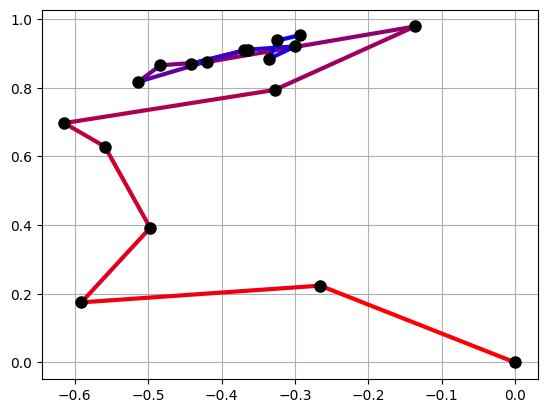

In [272]:
for i in range(len(xs) - 1):
    color_ratio = i / (len(xs) - 2) if len(xs) > 2 else 0.5
    color = (1 - color_ratio, 0, color_ratio)
    plt.plot([xs[i], xs[i+1]], [ys[i], ys[i+1]], color=color, linewidth=3)

plt.plot(xs, ys, 'ko', markersize=8)
plt.grid(True)
plt.show()

Проведем поиск наилучших гиперпараметров по сетке:

In [307]:
T0_grid = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
k_grid = [0.5, 0.8, 0.9, 0.95, 0.98, 0.99, 0.995, 0.998, 0.999]
sigma_grid = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
n_runs = 20
n_iter_grid = [10, 100, 1000, 10000]
x0 = (np.random.rand(), np.random.rand())
f_best = 0
for n_iter in n_iter_grid:
    f_mean_best = 0
    f_var_best = 0
    for T0, k, sigma in zip(T0_grid, k_grid, sigma_grid):
        f_mean = 0
        f_vals = []
        for i in range(n_runs):
            x, y, _, _ = simulated_annealing(f, x0, T0, k, sigma, R, n_iter)
            f_mean += f(x, y)
            f_vals.append(f(x, y))
            if (f(x, y) < f_best):
                f_best = f(x, y)
        f_mean /= n_runs # Выборочное среднее
        f_var = np.sum(np.power(np.array(f_vals) - f_mean, 2)) / (n_runs - 1) # Выборочная дисперсия
        if (f_mean < f_mean_best):
            f_mean_best = f_mean
            f_var_best = f_var
            T0_best = T0
            k_best = k
            sigma_best = sigma
    print(f"best params for n_iter = {n_iter}: T0 = {T0_best}, k = {k_best}, sigma = {sigma_best}, average function value: {f_mean_best}, variance: {f_var_best}")
print(f"total best function value: {f_best}")


best params for n_iter = 10: T0 = 0.5, k = 0.95, sigma = 0.5, average function value: -0.07479252092698643, variance: 0.08146633575515055
best params for n_iter = 100: T0 = 0.5, k = 0.95, sigma = 0.5, average function value: -0.34654499308505843, variance: 0.2884187834851154
best params for n_iter = 1000: T0 = 1, k = 0.98, sigma = 1, average function value: -1.0366119169224863, variance: 0.26084672406635734
best params for n_iter = 10000: T0 = 1, k = 0.98, sigma = 1, average function value: -0.7224488498618735, variance: 0.40090880746998125
total best function value: -1.288463594927432


Подводя итоги, метод имитации обжига работает намного лучше случайного поиска, однако даже он справляется с задачей не идеально. Возможно, при выборе других семейств функций алгоритм будет работать лучше.

## Сравнение со стандартными методами оптимизации

Сравним работу случайных алгоритмов с классическим методом градиентного спуска. Градиент функции равен
$$ \nabla f(x_1, x_2) = \begin{bmatrix}
3 x_1^2 \sin(\frac{1}{x_1}) - x_1 \cos(\frac{1}{x_1}) + 10 x_2^4 \cos(\frac{1}{x_2}) \\
40 x_1 x_2^3 \cos(\frac{1}{x_2}) + 10 x_1 x_2^2 \sin(\frac{1}{x_2})
\end{bmatrix} $$

In [315]:
def gradient_descent(grad, x, speed, n_iter):
    for i in range(n_iter):
        x -= speed * grad(x)
        if (np.linalg.norm(x) > 1):
            x = x / np.linalg.norm(x)
    return x

In [316]:
def f_grad(z):
    x, y = z
    return np.array(3 * x ** 2 * np.sin(1/x) - x * np.cos(1/x) + 10 * y ** 4 * np.cos(1/y), 40 * x * y ** 3 * np.cos(1/y) + 10 * x * y ** 2 * np.sin(1/y))

In [ ]:
x = np.random.rand()
y = np.random.rand()
x, y = gradient_descent(f_grad, np.array([x, y]), 0.01, 1000)
print(f"x = {x}, y = {y}, f(x, y) = {f(x, y)}")

x = 0.21640714498842303, y = 0.6628935960196963, f(x, y) = 0.015907114441769343


In [421]:
n_runs = 1000

f_mean = 0
f_best = 0
for i in range(n_runs):
    x = np.random.rand()
    y = np.random.rand()
    x, y = gradient_descent(f_grad, np.array([x, y]), 0.01, 1000)
    f_mean += f(x, y)
    f_vals.append(f(x, y))
    if (f(x, y) < f_best):
        f_best = f(x, y)
f_mean /= n_runs # Выборочное среднее
f_var = np.sum(np.power(np.array(f_vals) - f_mean, 2)) / (n_runs - 1) # Выборочная дисперсия
print(f"Average function value: {f_mean}, variance: {f_var}")
print(f"total best function value: {f_best}")

Average function value: -0.030825153752349038, variance: 0.01203022431867986
total best function value: -0.48358361116148985
